# ROB2004 Final Project - manipulation of objects

The goal of this project is to solve a simple manipulation task.

## Instructions
* Solve the problem below.
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a report (maximum 3 pages) in pdf format detailing the methodology you followed to solve the problem. You should add plots in the report (does not count for the page limit).
* This is an individual project (dual submission of code/report is not allowed)

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

To run this project, you need to install Mujoco and Pinocchio. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Problem

Implement controller(s) using the code skeleton below to get the robot to put the red cube inside the bowl and the blue cube on top of the tower of green cubes (without breaking the tower!).

<div>
<img src="./manipulation_scene.jpg" width="400"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy, scipy, cvxopt or proxQP
* You need to use at least one task-space controller
* You need to use at least one joint-space controll (with an inverse geometry method)
* You need to compensate for the gravity of the robot

In your report, describe the controllers you designed and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit). Do not copy-paste code in the report.

## Scene details
* The bowl is located 25cm forward and 40cm right of the robot.
* The green tower is located 35cm forward and 50cm to the left of the robot
* The blue cube is located 45cm forward and 20cm to the left of the robot
* The red cube is located 50cm in front of the robot
* The x axis of the robot base is pointing foward and its y axis is pointing to its left


In [1]:
# setup some librairies and display options
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import scipy

import time

# be careful we will only print the first 4 digits and round small numbers in arrays
np.set_printoptions(suppress=True, precision=4)

# this library contains the simulation and helper functions for the robot
from MujocoSim import FR3Sim

In [75]:
# this creates the simulation environment
my_robot = FR3Sim()

In [3]:
def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[:3, 3] = vector
    
    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[1:3, 1:3] = [[cos, -sin], [sin, cos]]
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:3:2,0:3:2] = [[cos, sin], [-sin, cos]]
    
    ### we return the object
    return transform


def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    cos = np.cos(angle)
    sin = np.sin(angle)
    transform[0:2,0:2] = [[cos, -sin], [sin, cos]]
    
    ### we return the object
    return transform

def forward_kinematics(q):
    T_01 = translate([0,0,0.3330]) @ rotateZ(q[0]) 
    T_12 = rotateX(-np.pi/2) @ rotateZ(q[1])
    T_23 = rotateX(np.pi/2) @ translate([0,0, 0.3160]) @ rotateZ(q[2])
    T_34 = translate([0.0825, 0, 0]) @ rotateX(np.pi/2) @ rotateZ(q[3])
    T_45 = rotateX(-np.pi/2) @ translate([-0.0825, 0 ,0.384]) @ rotateZ(q[4])
    T_56 = rotateX(np.pi/2) @ rotateZ(q[5])
    T_67 = rotateX(np.pi/2) @ translate([0.088,0,0]) @ rotateZ(q[6])
    T_7F = translate([0,0,0.107])
    T_0F = T_01 @ T_12 @ T_23 @ T_34 @ T_45 @ T_56 @ T_67 @ T_7F
    return T_0F


In [4]:
def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    T = t_goal - t_init
    t_diff = t - t_init
    pos_diff = position_goal - position_init

    desired_position = position_init + (10*(t_diff/T)**3 - 15*(t_diff/T)**4 + 6*(t_diff/T)**5) * (pos_diff)
    desired_velocity = (30*(t_diff**2)/(T**3) - 60*(t_diff**3)/(T**4) + 30*(t_diff**4)/(T**5)) * (pos_diff)
    
    return desired_position, desired_velocity

def fingertip_position_error(joint_angles, desired_fingertip_position):
    #joint_angles is an array of 7
    current_guess_position = my_robot.get_pose(joint_angles)[0:3,3]
    error = current_guess_position - desired_fingertip_position
    return error.dot(error)

def inverse_geometry(desired_fingertip_position):
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi),]
    x0, _ = my_robot.get_state()
    res = scipy.optimize.minimize(fingertip_position_error,x0, args=(desired_fingertip_position,),bounds=bounds)
    return res.x

In [74]:
my_robot.reset()

In [ ]:
#positions of all items in frame of robot base
item_positions = {"bowl": np.array([0.25, -0.4, 0]),
             "tower": np.array([0.35, 0.5, 0]),
             "blue_cube": np.array([0.45, 0.25, 0]),
             "red_cube": np.array([0.5, 0, 0]),
}


robot_rest_state = my_robot.get_state()[0]
print(robot_rest_state)
d_p = my_robot.get_pose(robot_rest_state)
print(d_p)
print(inverse_geometry(d_p[0:3, 3]))


[-0.     -0.7854  0.     -2.3562 -0.      1.5708  0.7854]
[[ 1.     -0.     -0.      0.3069]
 [-0.     -1.     -0.     -0.    ]
 [-0.      0.     -1.      0.5903]
 [ 0.      0.      0.      1.    ]]
[-0.     -0.7854  0.     -2.3562 -0.      1.5708  0.7854]


In [89]:
my_robot.reset()
phases = {"above_blue_cube": [np.array([0.5, 0.2, 0.4]), False],
           "claw_blue_cube": [np.array([0.45, 0.2, 0.12]), False],
           "above2_blue_cube": [np.array([0.5, 0.2, 0.4]), True],
            "near_tower": [np.array([0.34, 0.504, 0.335]), True],
             "drop_blue_cube": [np.array([0.35, 0.5, 0.4]), False],
             "above_red_cube": [np.array([0.55, 0, 0.4]), False],
          "claw_red_cube": [np.array([0.55, 0, 0.13]), False],
          "above2_red_cube": [np.array([0.55, 0, 0.4]), True],
          "above_bowl": [np.array([0.3, -0.4, 0.4]), True],
          "drop": [np.array([0.3, -0.4, 0.4]), False]}

phases_name = ["above_blue_cube",
               "claw_blue_cube",
               "above2_blue_cube",
               "near_tower",
               "drop_blue_cube",
               "above_red_cube",
               "claw_red_cube",
               "above2_red_cube",
               "above_bowl",
               "drop" ]

## the controller is run every 1ms
P = np.array([100, 100, 100, 100, 100, 100, 100])
D = np.array([100,100,100,100,100,100,100])

## sample control loop running for 5 seconds (i.e. 5/0.001 = 5000 steps)
t_goals = [8,8,8,8,8,8,8,8,5,3]

step = 0

run_time = sum(t_goals)
dt = 0.001
num_steps = int(run_time/dt)
t_start = time.time()


time0 = np.zeros([num_steps])

#arrays for storing data of joints 5, 6, 7
measured_joint5_6_7_angles = np.zeros([num_steps, 3])
desired_joint5_6_7_angles = np.zeros_like(measured_joint5_6_7_angles)
measured_joint5_6_7_velocity = np.zeros_like(measured_joint5_6_7_angles)
desired_joint5_6_7_velocity = np.zeros_like(measured_joint5_6_7_angles)


# we will store the end effector position (desired and measured)
measured_finger_position = np.zeros([num_steps,3])
measured_finger_velocity = np.zeros_like(measured_finger_position)

desired_finger_position = np.zeros_like(measured_finger_position)
desired_finger_velocity = np.zeros_like(measured_finger_position)


q0, dq0 = my_robot.get_state()
prev_pos = my_robot.get_pose(q0)[0:3, 3]
prev_t = 0 

for i in range(num_steps):
    time0[i] = i*dt
    # this function gets the joint positions and velocities
    q, dq = my_robot.get_state()
    
    goal_time = 0
    init_step = step
    for j in range(len(phases)):
        goal_time += t_goals[j]
        if time0[i] >= goal_time:
            step = j+1
        else:
            break
    
    if step != init_step:
        prev_t = time0[i]
        prev_pos = my_robot.get_pose(q)[0:3, 3]

    
    goal = phases[phases_name[step]][0]
    
    # this function computes the foward kinematics (given joint positions)
    # it returns an homogeneous transform
    T = my_robot.get_pose(q)
    R = my_robot.get_pose(q)[0:3,0:3]
    measured_finger_position[i,:] = T[0:3,3]
    p_measured = measured_finger_position[i]

    # this function computes the endeffector Jacobian (given joint positions)
    # the Jacobian maps joint velocities to endeffector twist (in endfefector frame! not worldframe)
    J = my_robot.get_jacobian(q)
    J = R @ J[3:, :]
    
    p_ref, v_ref = compute_trajectory(prev_pos, goal, prev_t, goal_time, time0[i])
    p_diff = p_ref - p_measured
    p_measured_dot = J @ dq
    d_diff = v_ref - p_measured_dot
    


    if np.linalg.norm(p_diff) <= 0.01 and step == 1:
        goal_name = phases_name[0] 
        goal_pos = phases[goal_name][0] 
        q_des = inverse_geometry(goal_pos)
        dq_des = [0,0,0,0,0,0.4,0.1]

        error = q_des - q
        d_error = dq_des - dq
        joint_torques = P * error + D * d_error
    elif np.linalg.norm(p_diff) <= 0.01 and step == 3:
        goal_name = phases_name[2] 
        goal_pos = phases[goal_name][0] 
        q_des = inverse_geometry(goal_pos)
        dq_des = [0,0,0,0,-0.05,-0.2,0.1]

        error = q_des - q
        d_error = dq_des - dq
        joint_torques = P * error + D * d_error
    elif np.linalg.norm(p_diff) <= 0.01 and step == 5:
        goal_name = phases_name[4] 
        goal_pos = phases[goal_name][0] 
        q_des = inverse_geometry(goal_pos)
        dq_des = [0,0,0,0,0.05,0,-0.4]

        error = q_des - q
        d_error = dq_des - dq
        joint_torques = P * error + D * d_error
    else:
        joint_torques = J.T @ ((np.diag(P[:3]) @ p_diff) + (np.diag(D[:3]) @ d_diff)) 
        

    measured_joint5_6_7_angles[i, :] = q[4:]
    desired_joint5_6_7_angles[i, :] = q_des[4:]
    measured_joint5_6_7_velocity[i, :] = dq[4:]
    desired_joint5_6_7_velocity[i, :] = dq_des[4:]

    measured_finger_position[i,:] = p_measured
    measured_finger_velocity[i,:] = p_measured_dot[0:3]
    desired_finger_position[i, :] = p_ref
    desired_finger_velocity[i, :] = v_ref

    ## this function get the gravity vector
    gravity = my_robot.get_gravity(q)
    joint_torques += gravity

    ## commands opening or closing of the gripper (positive number applies an opening force)
    ## it will also advance the simulation by 1ms
    if phases[phases_name[step]][1]:
        gripper = -10
    else:
        gripper = 10
    my_robot.send_joint_torque(joint_torques, gripper)
    time.sleep(max(sleep_time:=dt*(i+1) - (time.time()-t_start), 0))


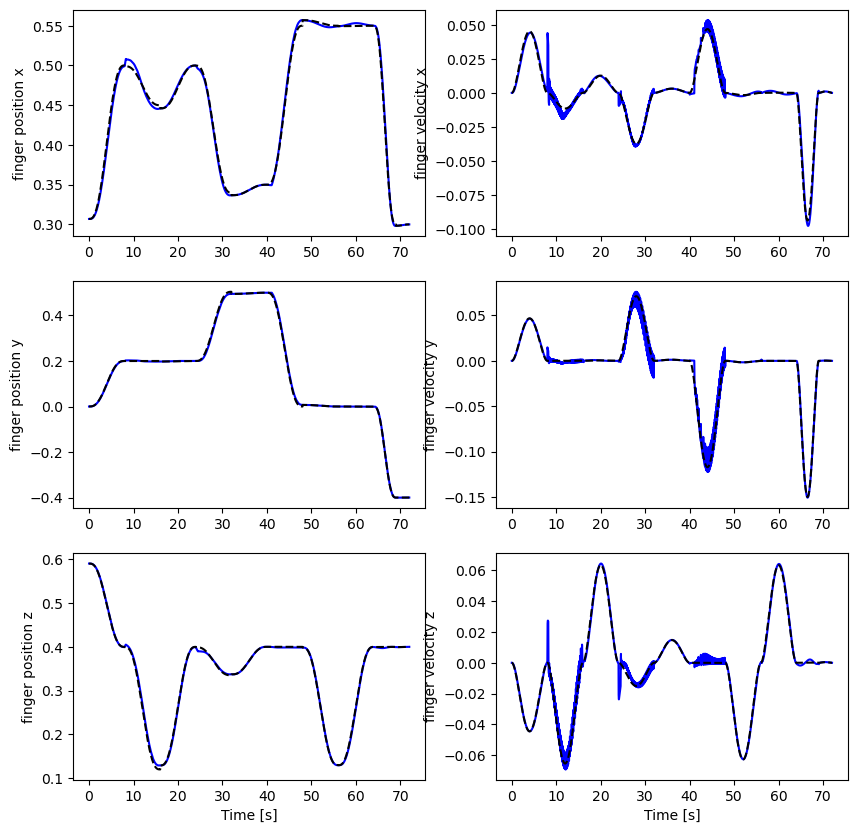

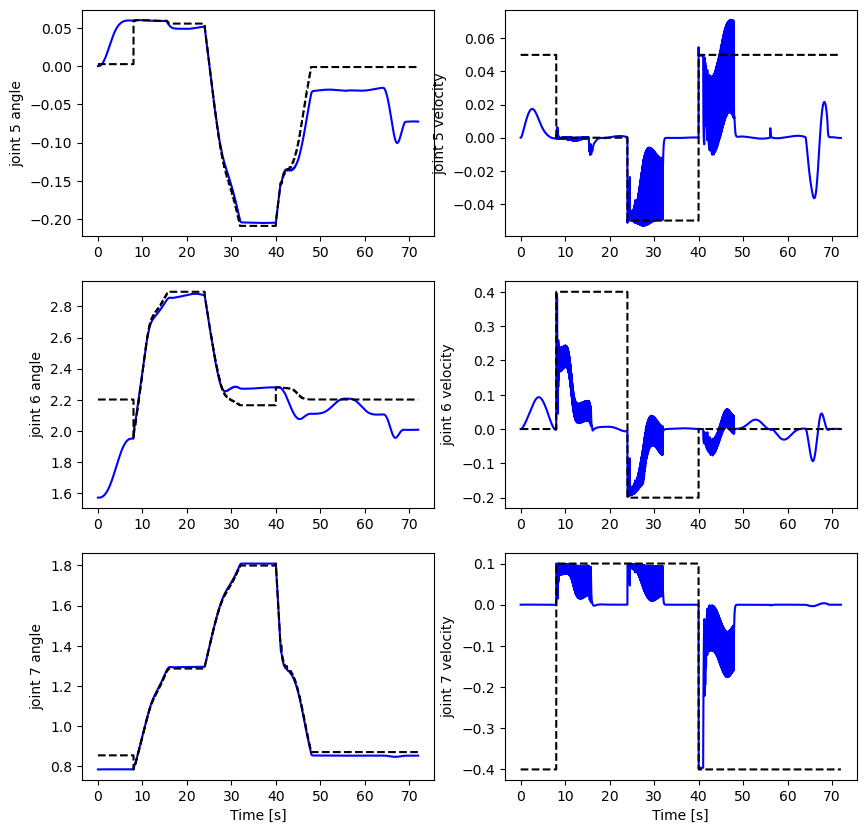

In [90]:
%matplotlib inline

def plot_finger_posvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'finger position x')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'finger position y')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'finger position z')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'finger velocity x')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'finger velocity y')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'finger velocity z')
    plt.xlabel('Time [s]')

    plt.show()

def plot_joint567_angvel(time, th, th_des, dth, dth_des):
    fig = plt.figure(figsize=(10,10))
    
    plt.subplot(3,2,1)
    plt.plot(time, th[:,0], 'b-', time, th_des[:,0], '--k')
    plt.ylabel(r'joint 5 angle')
    plt.subplot(3,2,3)
    plt.plot(time, th[:,1], 'b-', time, th_des[:,1], '--k')
    plt.ylabel(r'joint 6 angle')
    plt.subplot(3,2,5)
    plt.plot(time, th[:,2], 'b-', time, th_des[:,2], '--k')
    plt.ylabel(r'joint 7 angle')
    plt.xlabel('Time [s]')
    
    plt.subplot(3,2,2)
    plt.plot(time, dth[:,0], 'b-', time, dth_des[:,0], '--k')
    plt.ylabel(r'joint 5 velocity')
    plt.subplot(3,2,4)
    plt.plot(time, dth[:,1], 'b-', time, dth_des[:,1], '--k')
    plt.ylabel(r'joint 6 velocity')
    plt.subplot(3,2,6)
    plt.plot(time, dth[:,2], 'b-', time, dth_des[:,2], '--k')
    plt.ylabel(r'joint 7 velocity')
    plt.xlabel('Time [s]')

    plt.show()

plot_finger_posvel(time0, 
                   measured_finger_position, 
                   desired_finger_position, 
                   measured_finger_velocity,
                   desired_finger_velocity)

plot_joint567_angvel(time0, 
                   measured_joint5_6_7_angles, 
                   desired_joint5_6_7_angles, 
                   measured_joint5_6_7_velocity,
                   desired_joint5_6_7_velocity)